### Objective:

##### Identify which factors predict future user adoption.

Approach: 
- create a list of adopted users based on engagement dataset. Adopted users are those who have logged into the product on three separate days in at least one seven-day period.
- map the list back to user info dataset and run classification models to assess feature importance on prediction

In [75]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

##### Get Engagement Data

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [3]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
# Time stamp is not in datetime format, convert that to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], errors='coerce')

In [5]:
# Extact date as a new attribute
engagement['date'] = engagement['time_stamp'].dt.date

##### Creating shift features

This is to find if a particular has used product three times within a seven day period. Need to sort the dataframe by user_id & date first.

In [6]:
engage_sort = engagement.sort_values(by=['user_id', 'date'], ascending=True)

In [7]:
engage_sort['last_2_use'] = engage_sort['date'].shift(2)
engage_sort['id_match'] = engage_sort['user_id'].shift(2)

In [8]:
# Convert datetime day difference into integer
engage_sort['days_among_3_use'] = (engage_sort['date']-engage_sort['last_2_use'])/ np.timedelta64(1, 'D')

##### Create Adopt feature

- after shifting data down by two, if id match the user_id on the same row, then that user_id had used the product at least three times.
- if days_among_3_use has a value of seven or less, the user is adopted user, assign 1, otherwise 0.

In [9]:
engage_sort['adopt'] = np.where((engage_sort['days_among_3_use'] <=7) & (engage_sort['user_id'] == engage_sort['id_match']), 1, 0)

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
# groupby step to get final summary on user_id and adopt
engage_df = engage_sort.groupby(['user_id'], as_index=False).agg({'adopt': 'max'})

In [11]:
engage_df['adopt'].value_counts()

0    7167
1    1656
Name: adopt, dtype: int64

Average adoption rate is about **18.7%**

##### Get user data

In [14]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Add adopt attribute to the user data. For missing values, assume those users did not adopt since no engagement records exist.

In [16]:
user_engage = pd.merge(users, engage_df, left_on='object_id', right_on='user_id', how='outer')

In [17]:
user_engage['adopt'] = user_engage['adopt'].fillna(0)

In [18]:
user_engage.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopt
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,0.0


### Exploratory & Chi Square Test

The following attributes will be reviewed
- creation_source
- opted_in_to_mailing_list
- enabled_for_marketing_drip

These three features have small numbers of category and will be easier to run visualization and Chi Square Test

In [20]:
def form_crosstab(df, attr):
    """create crosstab dataframe among adoption across users

    Args:
    df: name of the dataframe
    attr: attributes in the dataframe

    Returns:
    crosstab table
    """
    table = pd.crosstab(df[attr], df['adopt'], values=df['adopt'],
                        aggfunc='count', normalize='index')
    return table

In [21]:
def bar_plot(data, var):
    """Stack bar chart to show the result of % of adopted users to total by attribute

    Args:
    data: crosstab table object
    var: attritbute in the dataframe

    Returns:
    stacked bar chart
    """
    data.plot.bar(stacked=True, figsize=(10, 5))
    plt.title('adoption rate by '+var, fontsize=20)
    plt.xlabel(var, fontsize=15)
    plt.ylabel('%', fontsize=15)
    plt.legend(('Not Adopt', 'Adopted'))
    plt.autoscale(enable=True)
    plt.show()

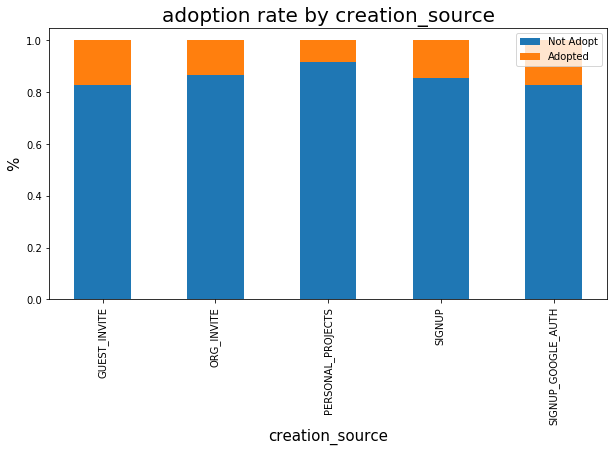

In [22]:
bar_plot(form_crosstab(user_engage, 'creation_source'), 'creation_source')

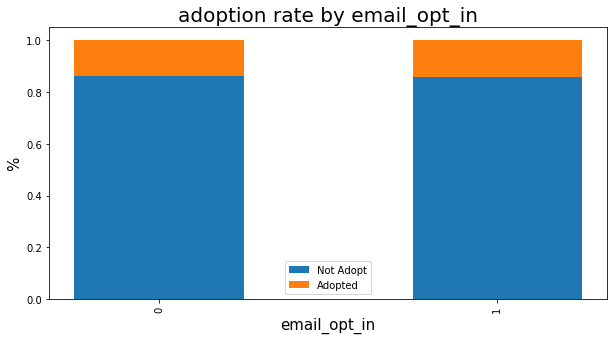

In [23]:
bar_plot(form_crosstab(user_engage, 'opted_in_to_mailing_list'), 'email_opt_in')

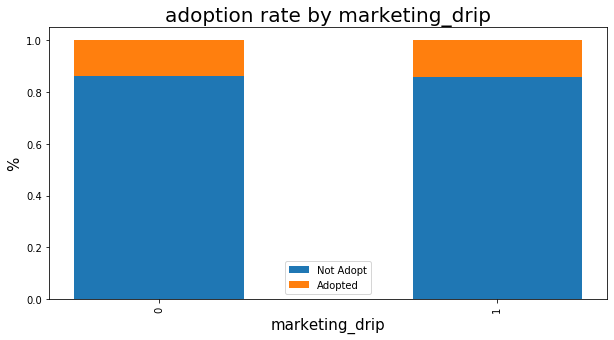

In [24]:
bar_plot(form_crosstab(user_engage, 'enabled_for_marketing_drip'), 'marketing_drip')

creation_source appears to have predictive value - Personal Project has the highest average engagement %
<br>
opted_in_to_mailing_list and enabled_for_marketing_drip do not appear to be influence adoption rates. We will run Chi-Square test to confirm.

In [19]:
def chi_sq_test(df, attr, target):
    """measure p-value of chi_sq test for attributes

    Args:
    attr: attribute that is being test

    Returns:
    p-values, degree of freedom
    """
    table = pd.crosstab(df[attr], df[target],
                        values=df[target], aggfunc='count')
    stat, p, dof, expected = stats.chi2_contingency(table[[0, 1]])
    print('attribute tested: {}'.format(attr))
    print('p-value: {:.2f}'.format(p))
    print('degree of freedom: {:.0f}'.format(dof))

In [22]:
chi_sq_test(user_engage, 'creation_source', 'adopt')

attribute tested: creation_source
p-value: 0.00
degree of freedom: 4


In [23]:
chi_sq_test(user_engage, 'opted_in_to_mailing_list', 'adopt')

attribute tested: opted_in_to_mailing_list
p-value: 0.35
degree of freedom: 1


In [24]:
chi_sq_test(user_engage, 'enabled_for_marketing_drip', 'adopt')

attribute tested: enabled_for_marketing_drip
p-value: 0.49
degree of freedom: 1


Both email opt_in_to_mailing_list and enabled_for_marketing_drip do not pass Chi Square Test. Conclude that they are not factors that predict user adoption

### Test with classification models

**Org id** and **invited_by_user_id** have many categories that won't be easy to evaluation through visualization and Chi Square test returned nan p-value.

Instead, we will put them into a classifiation model (Catboost in this case) and see if they can result in prediction better than average adoption rate of 18.7%.

In [129]:
X = user_engage[['invited_by_user_id']] #'invited_by_user_id'
y = user_engage['adopt']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [131]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [132]:
model = xgb.XGBClassifier(random_state=10)
model.fit(X_train, y_train)
accuracy_score = model.score(X_test, y_test)
print('Accuaracy Score: %.3f' % (accuracy_score))

Accuaracy Score: 0.861


In [133]:
pred_xgb = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, pred_xgb)
print('ROC AUC : %.3f' % (auc_score))

ROC AUC : 0.510


Baseline of accuracy is 81.3%. Model with the two features improved accuracy by ~5%. Depending on the success requirement, they may or may not matter.

The model has low AUC score 0.589 and is very close to 0.5, which suggests that the model is not a good classifier. But that could further be optimized as we are adding more features
We would lean on concluding that **Org_id** and **invited_by_user_id** are weak power featuresnot strong features on predicting user adoption.

#### Remaining Features Candidates

User name, account creation time, and latest session login time are random information that do not have predictive power to new data.

### Conclusion

Based on above analysis, only 